# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
import os
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

/Users/fairystories/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('all/extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('all/extracted_fields_test.gz', 
                   dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

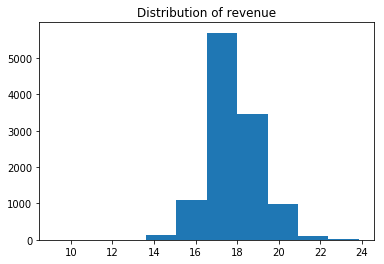

In [47]:
plt.hist(np.log1p(train.loc[train['totals.transactionRevenue'].isna() == False, 'totals.transactionRevenue']));
plt.title('Distribution of revenue');

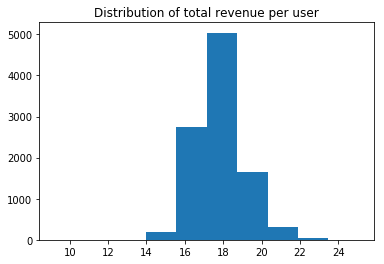

In [48]:
grouped = train.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
grouped = grouped.loc[grouped['totals.transactionRevenue'].isna() == False]
plt.hist(np.log(grouped.loc[grouped['totals.transactionRevenue'] > 0, 'totals.transactionRevenue']));
plt.title('Distribution of total revenue per user');

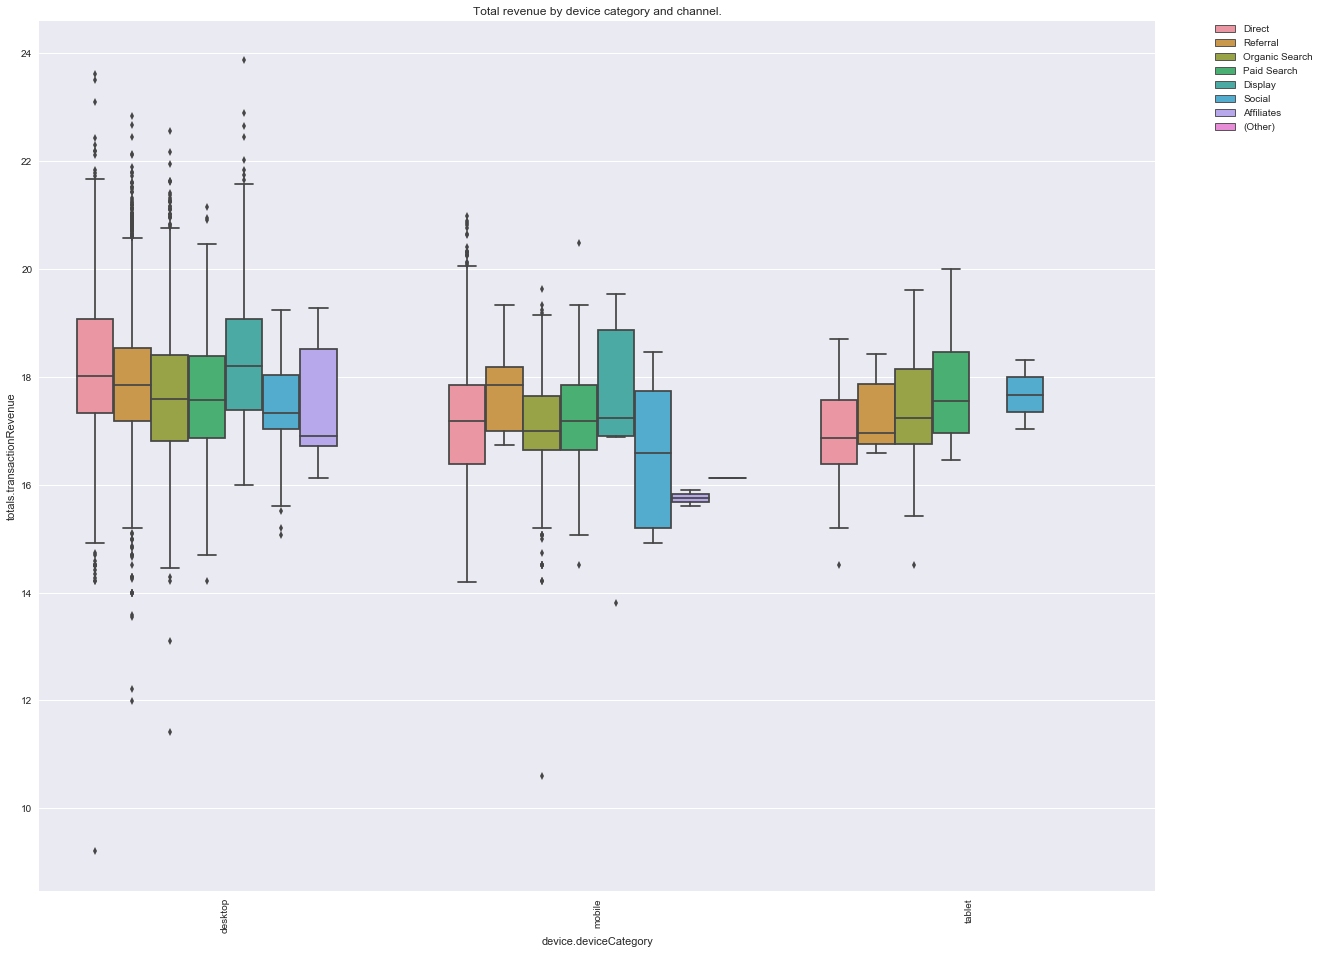

In [49]:
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'])
sns.set(rc={'figure.figsize':(20, 16)})
train_ = train.loc[train['totals.transactionRevenue'] > 0.0]
sns.boxplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping",  data=train_)
plt.title("Total revenue by device category and channel.");
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [3]:
print (train.sessionId.count(), train.sessionId.nunique())
print (test.sessionId.count(), test.sessionId.nunique())

903653 902755
804684 803863


In [4]:
len(set(train.sessionId).intersection(set(test.sessionId)))

5

In [5]:
y_reg = train['totals.transactionRevenue'].fillna(0)

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

# Add features

In [6]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [8]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day
    df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60


In [17]:
# https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe
def browser_mapping(x):
    browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
    if x in browsers:
        return x.lower()
    elif  ('android' in x) or ('samsung' in x) or ('mini' in x) or ('iphone' in x) or ('in-app' in x) or ('playstation' in x):
        return 'mobile browser'
    elif  ('mozilla' in x) or ('chrome' in x) or ('blackberry' in x) or ('nokia' in x) or ('browser' in x) or ('amazon' in x):
        return 'mobile browser'
    elif  ('lunascape' in x) or ('netscape' in x) or ('blackberry' in x) or ('konqueror' in x) or ('puffin' in x) or ('amazon' in x):
        return 'mobile browser'
    elif '(not set)' in x:
        return x
    else:
        return 'others'
    
    
def adcontents_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('placement' in x) | ('placememnt' in x):
        return 'placement'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'ad' in x:
        return 'ad'
    else:
        return 'others'
    
def source_mapping(x):
    if  ('google' in x):
        return 'google'
    elif  ('youtube' in x):
        return 'youtube'
    elif '(not set)' in x or 'nan' in x:
        return x
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'bing' in x:
        return 'bing'
    elif 'quora' in x:
        return 'quora'
    elif 'outlook' in x:
        return 'outlook'
    elif 'linkedin' in x:
        return 'linkedin'
    elif 'pinterest' in x:
        return 'pinterest'
    elif 'ask' in x:
        return 'ask'
    elif 'siliconvalley' in x:
        return 'siliconvalley'
    elif 'lunametrics' in x:
        return 'lunametrics'
    elif 'amazon' in x:
        return 'amazon'
    elif 'mysearch' in x:
        return 'mysearch'
    elif 'qiita' in x:
        return 'qiita'
    elif 'messenger' in x:
        return 'messenger'
    elif 'twitter' in x:
        return 'twitter'
    elif 't.co' in x:
        return 't.co'
    elif 'vk.com' in x:
        return 'vk.com'
    elif 'search' in x:
        return 'search'
    elif 'edu' in x:
        return 'edu'
    elif 'mail' in x:
        return 'mail'
    elif 'ad' in x:
        return 'ad'
    elif 'golang' in x:
        return 'golang'
    elif 'direct' in x:
        return 'direct'
    elif 'dealspotr' in x:
        return 'dealspotr'
    elif 'sashihara' in x:
        return 'sashihara'
    elif 'phandroid' in x:
        return 'phandroid'
    elif 'baidu' in x:
        return 'baidu'
    elif 'mdn' in x:
        return 'mdn'
    elif 'duckduckgo' in x:
        return 'duckduckgo'
    elif 'seroundtable' in x:
        return 'seroundtable'
    elif 'metrics' in x:
        return 'metrics'
    elif 'sogou' in x:
        return 'sogou'
    elif 'businessinsider' in x:
        return 'businessinsider'
    elif 'github' in x:
        return 'github'
    elif 'gophergala' in x:
        return 'gophergala'
    elif 'yandex' in x:
        return 'yandex'
    elif 'msn' in x:
        return 'msn'
    elif 'dfa' in x:
        return 'dfa'
    elif '(not set)' in x:
        return '(not set)'
    elif 'feedly' in x:
        return 'feedly'
    elif 'arstechnica' in x:
        return 'arstechnica'
    elif 'squishable' in x:
        return 'squishable'
    elif 'flipboard' in x:
        return 'flipboard'
    elif 't-online.de' in x:
        return 't-online.de'
    elif 'sm.cn' in x:
        return 'sm.cn'
    elif 'wow' in x:
        return 'wow'
    elif 'baidu' in x:
        return 'baidu'
    elif 'partners' in x:
        return 'partners'
    else:
        return 'others'

train['device.browser'] = train['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
train['trafficSource.adContent'] = train['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
train['trafficSource.source'] = train['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

test['device.browser'] = test['device.browser'].map(lambda x:browser_mapping(str(x).lower())).astype('str')
test['trafficSource.adContent'] = test['trafficSource.adContent'].map(lambda x:adcontents_mapping(str(x).lower())).astype('str')
test['trafficSource.source'] = test['trafficSource.source'].map(lambda x:source_mapping(str(x).lower())).astype('str')

def process_device(data_df):
    print("process device ...")
    data_df['source.country'] = data_df['trafficSource.source'] + '_' + data_df['geoNetwork.country']
    data_df['campaign.medium'] = data_df['trafficSource.campaign'] + '_' + data_df['trafficSource.medium']
    data_df['browser.category'] = data_df['device.browser'] + '_' + data_df['device.deviceCategory']
    data_df['browser.os'] = data_df['device.browser'] + '_' + data_df['device.operatingSystem']
    return data_df

train = process_device(train)
test = process_device(test)

def custom(data):
    print('custom..')
    data['device_deviceCategory_channelGrouping'] = data['device.deviceCategory'] + "_" + data['channelGrouping']
    data['channelGrouping_browser'] = data['device.browser'] + "_" + data['channelGrouping']
    data['channelGrouping_OS'] = data['device.operatingSystem'] + "_" + data['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            data[i + "_" + j] = data[i] + "_" + data[j]
    
    data['content.source'] = data['trafficSource.adContent'] + "_" + data['source.country']
    data['medium.source'] = data['trafficSource.medium'] + "_" + data['source.country']
    return data

train = custom(train)
test = custom(test)

process device ...
process device ...
custom..
custom..


In [18]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

categorical_features = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]

In [19]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source
230774,Organic Search,2016-10-21 05:57:46,0000010278554503158,0000010278554503158_1477029466,1.477029e+09,1.0,1.477029e+09,chrome,desktop,0.0,...,not available in demo dataset_chrome,not available in demo dataset_desktop,not available in demo dataset_Macintosh,not available in demo dataset_google,Australasia_chrome,Australasia_desktop,Australasia_Macintosh,Australasia_google,nan_google_New Zealand,organic_google_New Zealand
89784,Organic Search,2016-12-01 07:55:01,0000020424342248747,0000020424342248747_1480578901,1.480579e+09,1.0,1.480579e+09,chrome,desktop,0.0,...,Lima Region_chrome,Lima Region_desktop,Lima Region_Windows,Lima Region_google,South America_chrome,South America_desktop,South America_Windows,South America_google,nan_google_Peru,organic_google_Peru
683463,Organic Search,2017-02-12 02:24:53,0000027376579751715,0000027376579751715_1486866293,1.486866e+09,1.0,1.486866e+09,chrome,desktop,0.0,...,not available in demo dataset_chrome,not available in demo dataset_desktop,not available in demo dataset_Macintosh,not available in demo dataset_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,nan_google_United States,organic_google_United States
648840,Social,2017-03-27 15:45:16,0000039460501403861,0000039460501403861_1490629516,1.490630e+09,1.0,1.490630e+09,chrome,desktop,0.0,...,not available in demo dataset_chrome,not available in demo dataset_desktop,not available in demo dataset_Windows,not available in demo dataset_youtube,South America_chrome,South America_desktop,South America_Windows,South America_youtube,nan_youtube_Brazil,referral_youtube_Brazil
683201,Paid Search,2017-02-11 18:09:31,0000040862739425590,0000040862739425590_1486836571,1.486837e+09,1.0,1.486837e+09,chrome,desktop,0.0,...,California_chrome,California_desktop,California_Macintosh,California_google,Northern America_chrome,Northern America_desktop,Northern America_Macintosh,Northern America_google,nan_google_United States,cpc_google_United States


## Generate actual user-based training and test dataset¶

In [20]:
## test y dates
test_y_start_date = pd.to_datetime('2018-12-01')
test_y_end_date = pd.to_datetime('2019-01-31')

test_y_days = (test_y_end_date - test_y_start_date).days

## test x dates
test_x_start_date = pd.to_datetime('2018-05-01')
test_x_end_date = pd.to_datetime('2018-10-15')

test_days = test_x_end_date - test_x_start_date
test_days = test_days.days

test_diff_days = (test_y_start_date - test_x_start_date).days

## y and X dates
from datetime import timedelta as td
train_y_end_date = pd.to_datetime('2017-08-01') ## This needs to be updated when new train/test datasets were published
train_y_start_date = train_y_end_date - td(days=test_y_days)
print ("Training y start and end dates:", train_y_start_date, train_y_end_date)

train_x_start_date = train_y_start_date - td(days=test_diff_days)
train_x_end_date = train_x_start_date + td(days=test_days)
print ("Training X start and end dates:", train_x_start_date, train_x_end_date)

Training y start and end dates: 2017-06-01 00:00:00 2017-08-01 00:00:00
Training X start and end dates: 2016-10-30 00:00:00 2017-04-15 00:00:00


In [21]:
train_sess = train[(train['date']>=train_x_start_date) & (train['date']<=train_x_end_date)]
y_sess = train[(train['date']>=train_y_start_date) & (train['date']<=train_y_end_date)]
print ("training /test data shapes:", train_sess.shape, y_sess.shape)

x_visitors = train_sess.fullVisitorId.unique()
y_visitors = y_sess[y_sess['totals.transactionRevenue']>0].fullVisitorId.unique()
ratio_trans_vistors = len(set(x_visitors).intersection(set(y_visitors)))/len(x_visitors)
print ("\nOut of %d visitors only %d had generated transactions(revenues), the ratio of transaction is %f" \
       % (len(x_visitors), len(set(x_visitors).intersection(set(y_visitors))), ratio_trans_vistors))

training /test data shapes: (429198, 72) (135218, 72)

Out of 345029 visitors only 105 had generated transactions(revenues), the ratio of transaction is 0.000304


In [24]:
train_data = train_sess.groupby('fullVisitorId')['visitId'].count().reset_index().rename(columns={'visitId': 'sess_cnt'})
train_data = pd.merge(train_data,
                      y_sess.groupby('fullVisitorId')['totals.transactionRevenue'].agg(
                          [np.size, np.sum]).reset_index().rename(columns={'size': 'y_sess_cnt', 'sum': 'y_revenue'}),
                      how='left',
                      on='fullVisitorId'
                      ).fillna(0)
print(train_data.shape)
train_data.head()

(345029, 4)


,fullVisitorId,sess_cnt,y_sess_cnt,y_revenue
0,0000020424342248747,1,0.0,0.0
1,0000027376579751715,1,0.0,0.0
2,0000039460501403861,1,0.0,0.0
3,0000040862739425590,2,0.0,0.0
4,0000068403966359845,1,0.0,0.0


## Numerical features¶

In [25]:
num_vars = ['visitNumber',
            'device.isMobile',
            'totals.bounces',
            'totals.hits',
            'totals.newVisits',
            'totals.pageviews',
            'trafficSource.isTrueDirect',
            'sess_date_dow',
            'sess_date_hours',
            'sess_date_dom']
num_vars

['visitNumber',
 'device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.isTrueDirect',
 'sess_date_dow',
 'sess_date_hours',
 'sess_date_dom']

In [26]:
# https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion
from scipy.stats import skew, kurtosis

def p25(x):
    return np.percentile(x, 25)
def p50(x):
    return np.percentile(x, 50)
def p75(x):
    return np.percentile(x, 75)
def nunique(x):
    return np.size(np.unique(x))
def max_min(x):
    return np.max(x)-np.min(x)
def p75_p25(x):
    return np.percentile(x, 75)-np.percentile(x, 25)



def get_group_stats(df, stat_funcs, target_column, group_column, ranking=False, ranking_pct=True, keep_raw=False):
    aggr = df.groupby(group_column)[target_column].agg(stat_funcs.values()).reset_index()
    aggr.columns = [group_column] + [  target_column + '_' + k + '_by_' + group_column for k in stat_funcs.keys()]
    if keep_raw:
        aggr = df[[group_column]].merge(aggr, how='left', on=group_column)
    
    #rank
    if ranking:
        aggr[target_column + '_rank_by_' + group_column] = df.groupby(group_column)[target_column].rank(method='dense', 
                                                                                                    na_option='top',
                                                                                                    pct=ranking_pct)
    if keep_raw:
        aggr.drop(group_column, axis=1, inplace=True)
    return aggr

In [27]:
%%time
stat_funcs = {
    'count_unique': nunique,
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
#     'p25': p25,
#     'p50': p50,
#     'p75': p75,
    'skew': skew,
    'kurtosis': kurtosis,
#     'max_min': max_min,
#     'p75_p25': p75_p25
}


aggr_vars = []
for num_var in num_vars:
    print("Processing %s..." % (num_var))
    aggr = get_group_stats(train_sess, stat_funcs, target_column=num_var, group_column='fullVisitorId', 
                           ranking=False, ranking_pct=False)
    train_data = pd.merge(train_data, aggr, how='left', on='fullVisitorId')
    aggr_vars.extend(list(aggr.columns))
    aggr_vars.remove('fullVisitorId')
                         

Processing visitNumber...
Processing device.isMobile...
Processing totals.bounces...
Processing totals.hits...
Processing totals.newVisits...
Processing totals.pageviews...
Processing trafficSource.isTrueDirect...
Processing sess_date_dow...
Processing sess_date_hours...
Processing sess_date_dom...
CPU times: user 16min 4s, sys: 11.3 s, total: 16min 15s
Wall time: 15min 56s


## Categorical features

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse

In [29]:
cat_vars = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object')
]
cat_vars

['channelGrouping',
 'device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.campaign',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source',
 'source.country',
 'campaign.medium',
 'browser.category',
 'browser.os',
 'device_deviceCategory_channelGrouping',
 'channelGrouping_browser',
 'channelGrouping_OS',
 'geoNetwork.city_device.browser',
 'geoNetwork.city_device.deviceCategory',
 'geoNetwork.city_device.operatingSystem',
 'geoNetwork.city_trafficSource.source',
 'geoNetwork.continent_device.browser',
 'geoNetwork.continent_device.deviceCategory',
 'geoNetwork.continent_device.operatingSystem',
 'geoNetwork.continent_trafficSource.source',
 'geoNetwork.country_device.browser',
 'geoNetwork.country_device.de

In [30]:
train_cat_sparse_list = []
cat_sparse_vars = []
for cat_var in cat_vars:
    print ("Processing %s..." % (cat_var))
    train_aggr = train_sess[['fullVisitorId', cat_var]].fillna('NA').groupby('fullVisitorId')[cat_var].apply(list).apply(lambda x:','.join(x)).apply(lambda x:x.replace(' ', '').replace('.', '').replace('-', '').replace('_', ''))
    transformer = CountVectorizer(binary=True, max_features=100)
    train_cat_sparse_list.append(transformer.fit_transform(train_aggr).tocsr())
    cat_sparse_vars.extend([ cat_var+':'+ v for v in transformer.vocabulary_])


Processing channelGrouping...
Processing device.browser...
Processing device.deviceCategory...
Processing device.operatingSystem...
Processing geoNetwork.city...
Processing geoNetwork.continent...
Processing geoNetwork.country...
Processing geoNetwork.metro...
Processing geoNetwork.networkDomain...
Processing geoNetwork.region...
Processing geoNetwork.subContinent...
Processing trafficSource.adContent...
Processing trafficSource.campaign...
Processing trafficSource.keyword...
Processing trafficSource.medium...
Processing trafficSource.referralPath...
Processing trafficSource.source...
Processing source.country...
Processing campaign.medium...
Processing browser.category...
Processing browser.os...
Processing device_deviceCategory_channelGrouping...
Processing channelGrouping_browser...
Processing channelGrouping_OS...
Processing geoNetwork.city_device.browser...
Processing geoNetwork.city_device.deviceCategory...
Processing geoNetwork.city_device.operatingSystem...
Processing geoNetwor

In [33]:
train_x = sparse.hstack([train_data[aggr_vars].values, sparse.hstack(train_cat_sparse_list)]).tocsr()
train_y = np.log1p(train_data.y_revenue.values)
full_vars = aggr_vars + cat_sparse_vars
print (train_x.shape)
print (train_y.shape)

(345029, 4107)
(345029,)


# Baseline


In [35]:
# if the prediction is all zeros, calculate the mse
allzero_train_y = np.log1p(np.zeros(len(train_y)))
allzero_baseline = np.sqrt(mean_squared_error(train_y, allzero_train_y))
print ("All zero baseline is %f" % (allzero_baseline))

All zero baseline is 0.321633


# Cross Validation

In [36]:
# Stratified on whether or not revenue were observed
train_y_dummy = np.array([0 if x==0 else 1 for x in train_data.y_revenue.values])

from sklearn.model_selection import KFold,StratifiedKFold
kfolds = 5

skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=17)

In [46]:
lgb_params = {'objective': 'regression_l2', 
              'learning_rate': 0.05, 
              'metric': 'rmse', 'bagging_freq': 1, 
              'seed': 42, 'num_leaves': 31, 'verbose': 1,
              'max_depth': 31, 'min_gain_to_split': 0.5, 
              'feature_fraction': 0.5, 'bagging_fraction': 1, 
              'min_sum_hessian_in_leaf': 1, 
              'lambda_l2': 0, 'lambda_l1': 0}

lgb_cv = lgb.cv(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y
                            ),
                num_boost_round=100000,
                nfold=kfolds,
                folds=skf.split(train_x,train_y_dummy),
                stratified=False,
                early_stopping_rounds=50,
                verbose_eval=500)

best_lgb_score = min(lgb_cv['rmse-mean'])
best_lgb_iteration = len(lgb_cv['rmse-mean'])
print ('Best LightGBM score : %f, best iteration: %d' % (best_lgb_score, best_lgb_iteration))

Best LightGBM score : 0.319609, best iteration: 23


In [42]:
model = lgb.train(lgb_params,
                lgb.Dataset(train_x,
                            label=train_y,feature_name=full_vars
                            ),
                num_boost_round=best_lgb_iteration)


Plotting feature importances


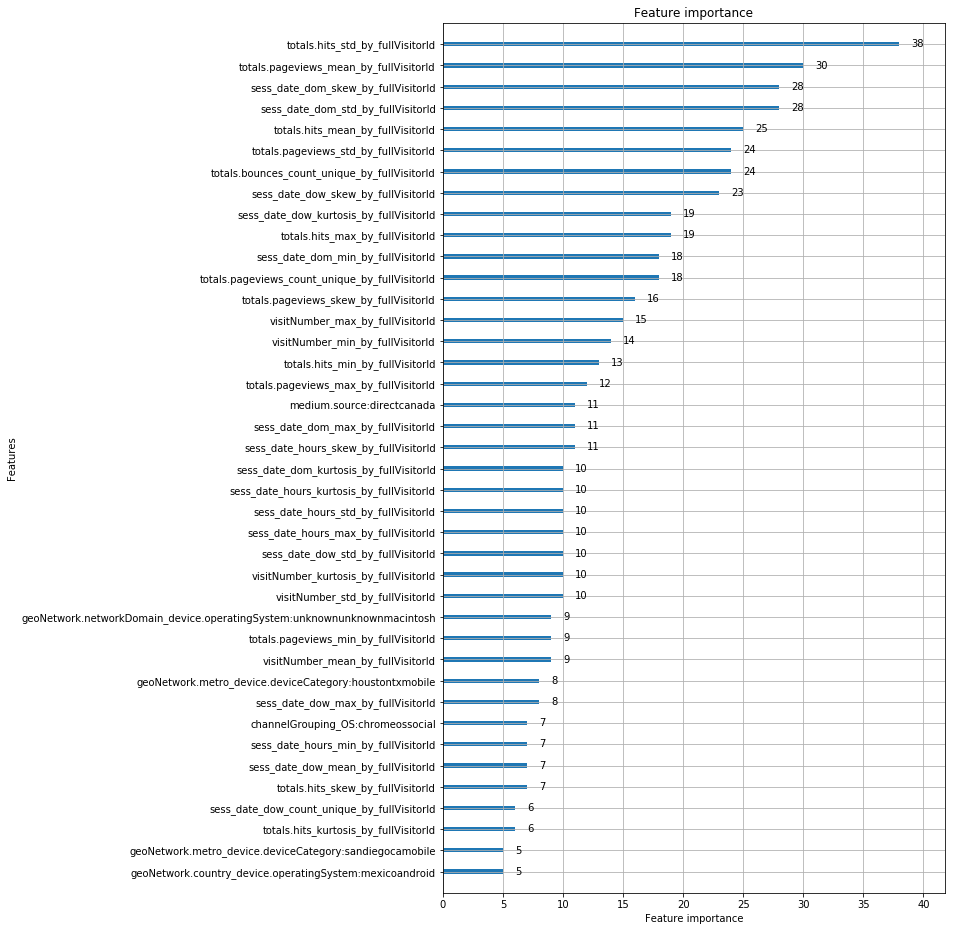

In [45]:
print('Plotting feature importances')
lgb.plot_importance(model, figsize=(9,16), max_num_features=40)


# references:

## https://www.kaggle.com/prashantkikani/teach-lightgbm-to-sum-predictions-fe

## https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/discussion

## https://www.kaggle.com/artgor/eda-on-basic-data-and-lgb-in-progress/notebook